In [1]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,12)

import requests
import json
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import LSTM, Softmax, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

**TABLE OF CONTENT**

--- 
# Data Query
## Prices Query
- Platform is coinBase
- BTC/USD price

In [2]:
url_call = 'https://min-api.cryptocompare.com/data/v2/histohour?fsym=BTC&tsym={}&limit={}&e=Coinbase'

# get data
currency = 'EUR'
n_batch_obs = 8
n_obs = n_batch_obs * 2000
reqs = []

if n_obs > 2000:
    
    # Initial Call
    req = json.loads(requests.get(url_call.format(currency, 2000)).text)
    print('- {}/BTC Prices from {} to {} '.format(currency, req['Data']['TimeFrom'], req['Data']['TimeTo']))
    reqs.append(req)
    
    for i in range(1, n_batch_obs):
        # Second query to ave double the history if n_obs > 2000
        req = json.loads(requests.get(url_call.format(currency, 2000) + '&toTs={}'.format(req['Data']['TimeFrom'])).text)
        print('- {}/BTC Prices from {} to {} '.format(currency, req['Data']['TimeFrom'], req['Data']['TimeTo']))
        reqs.append(req)

else:

    req = json.loads(requests.get(url_call.format(currency, n_obs)).text)
    print('- {}/BTC Prices from {} to {} '.format(currency, req['Data']['TimeFrom'], req['Data']['TimeTo']))
    reqs.append(req)



- EUR/BTC Prices from 1589007600 to 1596207600 
- EUR/BTC Prices from 1581807600 to 1589007600 
- EUR/BTC Prices from 1574607600 to 1581807600 
- EUR/BTC Prices from 1567407600 to 1574607600 
- EUR/BTC Prices from 1560207600 to 1567407600 
- EUR/BTC Prices from 1553007600 to 1560207600 
- EUR/BTC Prices from 1545807600 to 1553007600 
- EUR/BTC Prices from 1538607600 to 1545807600 


In [3]:
# Format as dataframe & sort DatetimeIndex
df = pd.concat([pd.DataFrame(req['Data']['Data']) for req in reqs], axis=0)
df.index = pd.to_datetime(df['time'], origin='unix', unit='s')
df.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
df.sort_index(ascending=True, inplace=True)
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15996 entries, 2018-10-03 23:00:00 to 2020-07-31 15:00:00
Data columns (total 6 columns):
close         15996 non-null float64
high          15996 non-null float64
low           15996 non-null float64
open          15996 non-null float64
volumefrom    15996 non-null float64
volumeto      15996 non-null float64
dtypes: float64(6)
memory usage: 874.8 KB


## News query

# Features Engineering
## Features Computation

In [4]:
def rolling_tscores(series, window):
    '''
    Compute the T-Score on the previous values from a rolling window
    in order to not calculate a t-score based on a distribution containing future values

    return: time series of the t-score based on previous values window sample
    '''

    # Get the rolling window
    roll_series = series.rolling(window)

    # Get the mean & std of the sample of previous records (distribution)
    m = roll_series.mean().shift(1)
    s = roll_series.std(ddof=0).shift(1)

    tscores = (series - m) / s

    return tscores

In [5]:
# original columns to keep
orig_cols = df.columns.tolist()[-2:]

#----------------------
# Movements and pct return (time step is hour)
periods = [1, 6, 12, 24]
movs_list = [df.diff(i) for i in periods]# + [df.pct_change(i) for i in periods]
movs_labels = []

for i in periods:
    # Labels for the time derivatives
    movs_labels += [col + '_mov{}H'.format(i) for col in df.columns]
    
#for i in periods:
    # Labels for pct change
    #movs_labels += [col + '_return{}H'.format(i) for col in df.columns]

# Concatenate
feats_df = pd.concat([df.loc[:, orig_cols]] + movs_list, axis=1)
feats_df.columns = orig_cols + movs_labels

print(feats_df.info())


#----------------------
# Rolling Statistics & T-Score
for col in feats_df.columns:
    # Get the series
    series = feats_df.loc[:, col]
    
    for i in periods[1:]:

        # Moving Averages series & combinations
        feats_df[col +'.MA{}H'.format(i)] = series.rolling("{}H".format(i)).mean()
        feats_df[col + '.MA{}H.diff'.format(i)] = series.rolling("{}H".format(i)).mean().diff()
        
        # Moving stats
        feats_df[col + '.MStd{}H'.format(i)] = series.rolling("{}H".format(i)).std()
        feats_df[col + '.MStd{}H.diff'.format(i)] = series.rolling("{}H".format(i)).std().diff()
        
        feats_df[col + '.MMin{}H'.format(i)] = series.rolling("{}H".format(i)).min()
        feats_df[col + '.MMin{}H.diff'.format(i)] = series.rolling("{}H".format(i)).min().diff()
        
        feats_df[col + '.MMax{}H'.format(i)] = series.rolling("{}H".format(i)).max()
        feats_df[col + '.MMax{}H.diff'.format(i)] = series.rolling("{}H".format(i)).max().diff()
        
        feats_df[col + '.MSum{}H'.format(i)] = series.rolling("{}H".format(i)).sum()
        feats_df[col + '.MSum{}H.diff'.format(i)] = series.rolling("{}H".format(i)).sum().diff()
      

        # T-Score on rolling 1 month & 6 months sample (tscore is zscore on a sample, not on whole distribution)
        feats_df[col + '.TScore6M'] = rolling_tscores(series=series, window='4400H')
        feats_df[col + '.TScore1M'] = rolling_tscores(series=series, window='720H')
        


print(feats_df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15996 entries, 2018-10-03 23:00:00 to 2020-07-31 15:00:00
Data columns (total 26 columns):
volumefrom           15996 non-null float64
volumeto             15996 non-null float64
close_mov1H          15995 non-null float64
high_mov1H           15995 non-null float64
low_mov1H            15995 non-null float64
open_mov1H           15995 non-null float64
volumefrom_mov1H     15995 non-null float64
volumeto_mov1H       15995 non-null float64
close_mov6H          15990 non-null float64
high_mov6H           15990 non-null float64
low_mov6H            15990 non-null float64
open_mov6H           15990 non-null float64
volumefrom_mov6H     15990 non-null float64
volumeto_mov6H       15990 non-null float64
close_mov12H         15984 non-null float64
high_mov12H          15984 non-null float64
low_mov12H           15984 non-null float64
open_mov12H          15984 non-null float64
volumefrom_mov12H    15984 non-null float64
volumeto_mov12H     

In [6]:
# suqared features
squared = []

for col in feats_df.columns:
    feats_df[col + '.Squared'] = feats_df[col] * feats_df[col]
    
feats_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15996 entries, 2018-10-03 23:00:00 to 2020-07-31 15:00:00
Columns: 1716 entries, volumefrom to volumeto_mov24H.MSum24H.diff.Squared
dtypes: float64(1716)
memory usage: 209.5 MB


In [7]:
# Check for Inf or Nan values
feats_df.dropna(inplace=True)
print(feats_df.info())
print('{} NaNs in the features'.format(feats_df.isnull().sum().sum()))
print('{} inf values in the features'.format(feats_df.isin([np.inf, -np.inf]).sum().sum()))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15948 entries, 2018-10-05 23:00:00 to 2020-07-31 15:00:00
Columns: 1716 entries, volumefrom to volumeto_mov24H.MSum24H.diff.Squared
dtypes: float64(1716)
memory usage: 208.9 MB
None
0 NaNs in the features
0 inf values in the features


## TArget Engineering
Target:
* 2 labels: up/down
* trend keep/change

Features derived from target
* difference of price from the min or max, average over last period


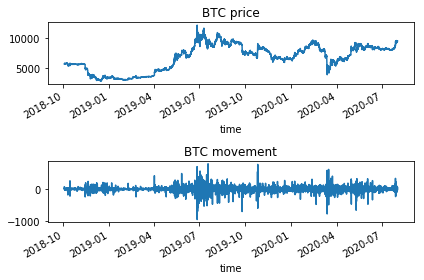

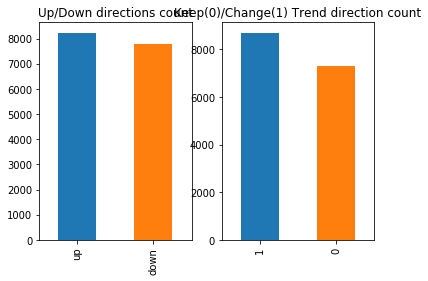

In [8]:
# PLOT OF THE BTC PRICE
fig, ax = plt.subplots(nrows=2)

_ = df['close'].plot(ax=ax[0], title='BTC price')
_ = df['close'].diff().plot(ax=ax[1], title='BTC movement')
_ = plt.tight_layout()

plt.show()

# 2 labels: up/down
price_mov = df['close'].diff().dropna()
price_mov_class = price_mov.apply(lambda x: 'up' if x>=0 else 'down')


fig, ax = plt.subplots(ncols=2)
_ = price_mov_class.value_counts().plot(kind='bar', title='Up/Down directions count', ax=ax[0])

# Same/Different trend as previous one
price_trend = (price_mov_class == price_mov_class.shift(1)).dropna()
price_trend = price_trend.map({True: 0, False: 1})

_ = price_trend.value_counts().plot(kind='bar', title='Keep(0)/Change(1) Trend direction count', ax=ax[1])

plt.show()


In [9]:
target = price_trend
class_weights = price_trend.value_counts().to_dict()
print(target)
print(class_weights)

time
2018-10-04 00:00:00    1
2018-10-04 01:00:00    0
2018-10-04 02:00:00    0
2018-10-04 03:00:00    1
2018-10-04 04:00:00    1
2018-10-04 05:00:00    1
2018-10-04 06:00:00    0
2018-10-04 07:00:00    1
2018-10-04 08:00:00    0
2018-10-04 09:00:00    1
2018-10-04 10:00:00    0
2018-10-04 11:00:00    1
2018-10-04 12:00:00    1
2018-10-04 13:00:00    1
2018-10-04 14:00:00    1
2018-10-04 15:00:00    1
2018-10-04 16:00:00    0
2018-10-04 17:00:00    0
2018-10-04 18:00:00    0
2018-10-04 19:00:00    0
2018-10-04 20:00:00    1
2018-10-04 21:00:00    1
2018-10-04 22:00:00    0
2018-10-04 23:00:00    1
2018-10-05 00:00:00    1
2018-10-05 01:00:00    1
2018-10-05 02:00:00    0
2018-10-05 03:00:00    1
2018-10-05 04:00:00    1
2018-10-05 05:00:00    1
                      ..
2020-07-30 10:00:00    0
2020-07-30 11:00:00    0
2020-07-30 12:00:00    0
2020-07-30 13:00:00    1
2020-07-30 14:00:00    1
2020-07-30 15:00:00    1
2020-07-30 16:00:00    0
2020-07-30 17:00:00    0
2020-07-30 18:00:00 

## Features Selection, Splitting
Kbest with f_classif criteria

In [10]:
# Align the features & Target indexes
feats_df['target'] = target
feats_df.dropna(inplace=True)
target = feats_df['target']
feats_df.drop(columns=['target'], inplace=True)

# Keep the 400 most relevant features
n_best = 400
kbest_selector = SelectKBest(f_classif, n_best)

# Fit on data
kbest_values = kbest_selector.fit_transform(feats_df, target)
kbest_df = pd.DataFrame(kbest_values,
                        index=feats_df.index,
                        columns=feats_df.loc[:, kbest_selector.get_support().tolist()].columns)

kbest_df.info()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass k=400 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15948 entries, 2018-10-05 23:00:00 to 2020-07-31 15:00:00
Columns: 400 entries, volumefrom to volumeto_mov24H.MMax12H.diff.Squared
dtypes: float64(400)
memory usage: 48.8 MB


In [11]:
# Add the 3rd dimension for the lags
look_back = 6

lagged = []
labels = []

# Add Lagged Features (from last to newest)
for l in range(look_back, 0, -1):
    print('- compute lag {}'.format(l))
    lagged.append(kbest_df.shift(l))
    labels += ['{}(t{})'.format(col, l) for col in kbest_df.columns]

# Add actual features dataframe (no lag)
lagged.append(kbest_df)
labels += kbest_df.columns.tolist()

# Put together into DF
third_df = pd.concat(lagged, axis=1)
third_df.columns = labels


# Align the features & Target indexes
third_df['target'] = target
third_df.dropna(inplace=True)
target = third_df['target']
third_df.drop(columns=['target'], inplace=True)


third_df.info()

- compute lag 6
- compute lag 5
- compute lag 4
- compute lag 3
- compute lag 2
- compute lag 1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15942 entries, 2018-10-06 05:00:00 to 2020-07-31 15:00:00
Columns: 2800 entries, volumefrom(t6) to volumeto_mov24H.MMax12H.diff.Squared
dtypes: float64(2800)
memory usage: 340.7 MB


In [12]:
# Split the data - validation on 1 week
batch_size = 32
n_test = 40 * batch_size
n_val = 10 * batch_size

# Number of obs to keep in train set to have a round number of batches
n_train = int((len(third_df) -n_test-n_val) / batch_size) * batch_size
print(len(third_df)-n_test-n_val)
print(int((len(third_df) -n_test-n_val) / batch_size))

print('Train: {}, Test:{}, Validation:{}'.format(n_train, n_test, n_val))

# Features splitting & Scaling
X_all = third_df.values
X_train = X_all[-n_train-n_test-n_val:-n_test-n_val, :]
X_test = X_all[-n_test-n_val:-n_val, :]
X_val = X_all[-n_val:, :]

print('- Features arrays shapes: {} {} {} {}'.format(X_all.shape, X_train.shape, X_test.shape, X_val.shape))

# Scale the values between [-1,1]
X_scaler = MinMaxScaler((-1,1))

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
X_val = X_scaler.transform(X_val)

# Reshape
X_train = X_train.reshape(n_train, look_back+1, n_best)
X_test = X_test.reshape(n_test, look_back+1, n_best)
X_val = X_val.reshape(n_val, look_back+1, n_best)

print('- Features arrays shapes: {} {} {}'.format(X_train.shape, X_test.shape, X_val.shape))

# Targets
y_all = target.values
y_train = y_all[-n_train-n_test-n_val:-n_test-n_val]
y_test = y_all[-n_test-n_val:-n_val]
y_val = y_all[-n_val:]

print('- Target arrays shapes: {} {} {}'.format(y_train.shape, y_test.shape, y_val.shape))


14342
448
Train: 14336, Test:1280, Validation:320
- Features arrays shapes: (15942, 2800) (14336, 2800) (1280, 2800) (320, 2800)
- Features arrays shapes: (14336, 7, 400) (1280, 7, 400) (320, 7, 400)
- Target arrays shapes: (14336,) (1280,) (320,)


## Model: LSTM 

In [13]:
# LSTM parameters
lr = 1e-5
n_epochs = 6000
activation = 'tanh'
dr = 0.25

In [14]:
# Network Architecture
lstm = Sequential()


lstm.add(LSTM(200, activation=activation, stateful=True,
              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
              return_sequences=True, dropout=dr, recurrent_dropout=dr))

lstm.add(LSTM(200, activation=activation, stateful=True,
              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
              return_sequences=True, dropout=dr, recurrent_dropout=dr))

lstm.add(LSTM(100, activation=activation, stateful=True,
              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
              return_sequences=True, dropout=dr, recurrent_dropout=dr))

lstm.add(LSTM(40, activation=activation, stateful=True,
              batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]),
              return_sequences=False, dropout=dr, recurrent_dropout=dr))

# Output layer
lstm.add(Dense(units=1, activation='sigmoid'))


print(lstm.summary())


W0731 17:11:30.841953 4554251712 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 7, 200)              480800    
_________________________________________________________________
lstm_1 (LSTM)                (32, 7, 200)              320800    
_________________________________________________________________
lstm_2 (LSTM)                (32, 7, 100)              120400    
_________________________________________________________________
lstm_3 (LSTM)                (32, 40)                  22560     
_________________________________________________________________
dense (Dense)                (32, 1)                   41        
Total params: 944,601
Trainable params: 944,601
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Fitting across epochs
callbacks = [ReduceLROnPlateau(monitor="loss", factor=0.5, patience=10, 
                               mode="auto", min_delta=0.0001, min_lr=1e-9)]

In [17]:
# Compiling Optimizer
rmsprop = RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
lstm.compile(loss=BinaryCrossentropy(), optimizer=rmsprop, 
            metrics=['accuracy'])



# loss arrays
train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

counter = 1

for n in range(n_epochs):
    print('** epoch {}/{} **'.format(counter, n_epochs))

    history = lstm.fit(x=X_train, y=y_train, epochs=1, validation_data=(X_test, y_test),
                       batch_size=batch_size, shuffle=False, callbacks=callbacks,
                      class_weight=class_weights,
                      use_multiprocessing=True)

    # Append the list to follow the evolution of loss on train and test sets
    train_loss_list.append(history.history['loss'][0])
    train_acc_list.append(history.history['acc'][0])
    
    test_loss_list.append(history.history['val_loss'][0])
    test_acc_list.append(history.history['val_acc'][0])

    # Reset the cell states (required for stateful)
    lstm.reset_states()

    counter += 1


** epoch 1/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 28s 2ms/sample - loss: 5483.0311 - acc: 0.5413 - val_loss: 0.6907 - val_acc: 0.5586
** epoch 2/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 29s 2ms/sample - loss: 5483.1244 - acc: 0.5414 - val_loss: 0.6908 - val_acc: 0.5586
** epoch 3/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 31s 2ms/sample - loss: 5475.6302 - acc: 0.5412 - val_loss: 0.6906 - val_acc: 0.5586
** epoch 4/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 32s 2ms/sample - loss: 5480.7542 - acc: 0.5416 - val_loss: 0.6906 - val_acc: 0.5586
** epoch 5/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 33s 2ms/sample - loss: 5475.1590 - acc: 0.5415 - val_loss: 0.6904 - val_acc: 0.5586
** ep

14336/14336 [==============================] - 45s 3ms/sample - loss: 5470.3543 - acc: 0.5415 - val_loss: 0.6889 - val_acc: 0.5586
** epoch 43/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 45s 3ms/sample - loss: 5475.2169 - acc: 0.5415 - val_loss: 0.6891 - val_acc: 0.5586
** epoch 44/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 45s 3ms/sample - loss: 5472.3109 - acc: 0.5415 - val_loss: 0.6892 - val_acc: 0.5586
** epoch 45/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 44s 3ms/sample - loss: 5469.3210 - acc: 0.5415 - val_loss: 0.6892 - val_acc: 0.5586
** epoch 46/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 45s 3ms/sample - loss: 5470.2789 - acc: 0.5415 - val_loss: 0.6894 - val_acc: 0.5586
** epoch 47/6000 **
Train on 14336 samples, validate on 1280 samples


14336/14336 [==============================] - 49s 3ms/sample - loss: 5472.1345 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 84/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 50s 3ms/sample - loss: 5468.0446 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 85/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 49s 3ms/sample - loss: 5470.8021 - acc: 0.5415 - val_loss: 0.6889 - val_acc: 0.5586
** epoch 86/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 49s 3ms/sample - loss: 5468.4338 - acc: 0.5415 - val_loss: 0.6891 - val_acc: 0.5586
** epoch 87/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 49s 3ms/sample - loss: 5471.0430 - acc: 0.5415 - val_loss: 0.6891 - val_acc: 0.5586
** epoch 88/6000 **
Train on 14336 samples, validate on 1280 samples


14336/14336 [==============================] - 53s 4ms/sample - loss: 5468.9746 - acc: 0.5415 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 125/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 53s 4ms/sample - loss: 5471.0383 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 126/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 53s 4ms/sample - loss: 5470.8698 - acc: 0.5415 - val_loss: 0.6889 - val_acc: 0.5586
** epoch 127/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 53s 4ms/sample - loss: 5471.7615 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 128/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 53s 4ms/sample - loss: 5466.6952 - acc: 0.5415 - val_loss: 0.6888 - val_acc: 0.5586
** epoch 129/6000 **
Train on 14336 samples, validate on 1280 sam

14336/14336 [==============================] - 59s 4ms/sample - loss: 5470.0980 - acc: 0.5415 - val_loss: 0.6887 - val_acc: 0.5586
** epoch 166/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 59s 4ms/sample - loss: 5467.4563 - acc: 0.5415 - val_loss: 0.6887 - val_acc: 0.5586
** epoch 167/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 59s 4ms/sample - loss: 5470.5401 - acc: 0.5415 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 168/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 59s 4ms/sample - loss: 5469.5607 - acc: 0.5415 - val_loss: 0.6890 - val_acc: 0.5586
** epoch 169/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 60s 4ms/sample - loss: 5472.0789 - acc: 0.5415 - val_loss: 0.6889 - val_acc: 0.5586
** epoch 170/6000 **
Train on 14336 samples, validate on 1280 sam

14336/14336 [==============================] - 67s 5ms/sample - loss: 5469.0656 - acc: 0.5415 - val_loss: 0.6891 - val_acc: 0.5586
** epoch 207/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 68s 5ms/sample - loss: 5468.1784 - acc: 0.5415 - val_loss: 0.6888 - val_acc: 0.5586
** epoch 208/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 68s 5ms/sample - loss: 5466.2863 - acc: 0.5415 - val_loss: 0.6888 - val_acc: 0.5586
** epoch 209/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 69s 5ms/sample - loss: 5467.7713 - acc: 0.5415 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 210/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 68s 5ms/sample - loss: 5468.4841 - acc: 0.5415 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 211/6000 **
Train on 14336 samples, validate on 1280 sam

14336/14336 [==============================] - 73s 5ms/sample - loss: 5468.2556 - acc: 0.5415 - val_loss: 0.6891 - val_acc: 0.5586
** epoch 248/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 74s 5ms/sample - loss: 5469.2067 - acc: 0.5415 - val_loss: 0.6888 - val_acc: 0.5586
** epoch 249/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 74s 5ms/sample - loss: 5471.3390 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 250/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 79s 5ms/sample - loss: 5469.8565 - acc: 0.5415 - val_loss: 0.6889 - val_acc: 0.5586
** epoch 251/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 75s 5ms/sample - loss: 5467.5550 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 252/6000 **
Train on 14336 samples, validate on 1280 sam

14336/14336 [==============================] - 82s 6ms/sample - loss: 5468.9750 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 289/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 82s 6ms/sample - loss: 5466.1315 - acc: 0.5415 - val_loss: 0.6884 - val_acc: 0.5586
** epoch 290/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 85s 6ms/sample - loss: 5468.9210 - acc: 0.5415 - val_loss: 0.6889 - val_acc: 0.5586
** epoch 291/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 82s 6ms/sample - loss: 5468.6409 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 292/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 90s 6ms/sample - loss: 5468.9616 - acc: 0.5415 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 293/6000 **
Train on 14336 samples, validate on 1280 sam

** epoch 329/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 115s 8ms/sample - loss: 5469.1917 - acc: 0.5416 - val_loss: 0.6889 - val_acc: 0.5586
** epoch 330/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 106s 7ms/sample - loss: 5471.2842 - acc: 0.5416 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 331/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 119s 8ms/sample - loss: 5467.7375 - acc: 0.5416 - val_loss: 0.6887 - val_acc: 0.5586
** epoch 332/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 110s 8ms/sample - loss: 5466.3650 - acc: 0.5416 - val_loss: 0.6888 - val_acc: 0.5586
** epoch 333/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 114s 8ms/sample - loss: 5469.5462 - acc: 0.5415 - val_loss: 0.6890 - val_ac

14336/14336 [==============================] - 125s 9ms/sample - loss: 5465.6715 - acc: 0.5418 - val_loss: 0.6886 - val_acc: 0.5586
** epoch 370/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 125s 9ms/sample - loss: 5467.0821 - acc: 0.5419 - val_loss: 0.6888 - val_acc: 0.5586
** epoch 371/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 123s 9ms/sample - loss: 5467.1361 - acc: 0.5419 - val_loss: 0.6888 - val_acc: 0.5586
** epoch 372/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 121s 8ms/sample - loss: 5468.1046 - acc: 0.5415 - val_loss: 0.6884 - val_acc: 0.5586
** epoch 373/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 146s 10ms/sample - loss: 5469.6069 - acc: 0.5418 - val_loss: 0.6887 - val_acc: 0.5586
** epoch 374/6000 **
Train on 14336 samples, validate on 12

14336/14336 [==============================] - 156s 11ms/sample - loss: 5466.1854 - acc: 0.5423 - val_loss: 0.6881 - val_acc: 0.5586
** epoch 410/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 167s 12ms/sample - loss: 5465.5246 - acc: 0.5421 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 411/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 173s 12ms/sample - loss: 5469.9461 - acc: 0.5423 - val_loss: 0.6887 - val_acc: 0.5586
** epoch 412/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 168s 12ms/sample - loss: 5466.7349 - acc: 0.5422 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 413/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 179s 12ms/sample - loss: 5467.0814 - acc: 0.5422 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 414/6000 **
Train on 14336 samples, validate o

14336/14336 [==============================] - 164s 11ms/sample - loss: 5467.3550 - acc: 0.5425 - val_loss: 0.6883 - val_acc: 0.5586
** epoch 450/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 178s 12ms/sample - loss: 5467.4823 - acc: 0.5422 - val_loss: 0.6881 - val_acc: 0.5586
** epoch 451/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 188s 13ms/sample - loss: 5465.3444 - acc: 0.5424 - val_loss: 0.6887 - val_acc: 0.5586
** epoch 452/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 165s 11ms/sample - loss: 5466.5349 - acc: 0.5418 - val_loss: 0.6885 - val_acc: 0.5586
** epoch 453/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 177s 12ms/sample - loss: 5466.8839 - acc: 0.5419 - val_loss: 0.6884 - val_acc: 0.5586
** epoch 454/6000 **
Train on 14336 samples, validate o

14336/14336 [==============================] - 218s 15ms/sample - loss: 5466.5176 - acc: 0.5430 - val_loss: 0.6877 - val_acc: 0.5586
** epoch 490/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 232s 16ms/sample - loss: 5464.5127 - acc: 0.5423 - val_loss: 0.6881 - val_acc: 0.5586
** epoch 491/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 241s 17ms/sample - loss: 5464.5465 - acc: 0.5425 - val_loss: 0.6879 - val_acc: 0.5586
** epoch 492/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 229s 16ms/sample - loss: 5464.4290 - acc: 0.5423 - val_loss: 0.6879 - val_acc: 0.5586
** epoch 493/6000 **
Train on 14336 samples, validate on 1280 samples
14336/14336 [==============================] - 230s 16ms/sample - loss: 5462.0542 - acc: 0.5423 - val_loss: 0.6877 - val_acc: 0.5586
** epoch 494/6000 **
Train on 14336 samples, validate o


KeyboardInterrupt



In [ ]:
# Plot the errors
fig, ax = plt.subplots(nrows=4)
_ = ax[0].plot(range(1, counter), train_loss_list)
_ = ax[0].set_title('Binary Crossentropy Loss on train set')

_ = ax[1].plot(range(1, counter), train_acc_list)
_ = ax[1].set_title('Accuracy Loss on train set')

_ = ax[2].plot(range(1, counter), test_loss_list)
_ = ax[2].set_title('Binary Crossentropy Loss on test set')

_ = ax[3].plot(range(1, counter), test_acc_list)
_ = ax[3].set_title('Accuracy Loss on test set')

plt.show()


In [ ]:
# Save model
model_path = os.path.join(os.path.abspath('../'), 'Trained/BTC_{}ep.h5'.format(n_epochs))
lstm.save(model_path)


In [ ]:
# Predict n validation set
y_pred = lstm.predict(X_val)
print(y_val)
print(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm)

In [ ]:
# Load model
lstm = load_model(model_path)

# Resume training
n_epochs_resume = 1000

for n in range(n_epochs_resume):
    print('epoch {}/{} **'.format(counter, n_epochs_resume))

    history = lstm.fit(x=X_train, y=y_train, epochs=1, validation_data=(X_test, y_test),
                       batch_size=batch_size, shuffle=False, callbacks=callbacks,
                      class_weight=class_weights,
                      use_multiprocessing=True)

    # Append the list to follow the evolution of loss on train and test sets
    train_loss_list.append(history.history['loss'][0])
    train_acc_list.append(history.history['accuracy'][0])
    
    test_loss_list.append(history.history['val_loss'][0])
    test_acc_list.append(history.history['val_accuracy'][0])


    # Reset the cell states (required for stateful)
    lstm.reset_states()

    counter += 1

In [ ]:
# Plot the errors
fig, ax = plt.subplots(nrows=4)
_ = ax[0].plot(range(1, counter), train_loss_list)
_ = ax[0].set_title('Binary Crossentropy Loss on train set')

_ = ax[1].plot(range(1, counter), train_acc_list)
_ = ax[1].set_title('Accuracy Loss on train set')

_ = ax[2].plot(range(1, counter), test_loss_list)
_ = ax[2].set_title('Binary Crossentropy Loss on test set')

_ = ax[3].plot(range(1, counter), test_acc_list)
_ = ax[3].set_title('Accuracy Loss on test set')

plt.show()


In [ ]:
# Save model
model_path = 'BTC_{}ep.h5'.format(n_epochs+n_epochs_resume)
lstm.save(model_path)


In [ ]:
# Load model
lstm = load_model('BTC_2000ep.h5')
counter = 2000

# Resume training
n_epochs_resume = 1000

for n in range(n_epochs_resume):
    print('epoch {}/{} **'.format(counter, n_epochs_resume))

    history = lstm.fit(x=X_train, y=y_train, epochs=1, validation_data=(X_test, y_test),
                       batch_size=batch_size, shuffle=False, callbacks=callbacks,
                      class_weight=class_weights,
                      use_multiprocessing=True)

    # Append the list to follow the evolution of loss on train and test sets
    train_loss_list.append(history.history['loss'][0])
    train_acc_list.append(history.history['accuracy'][0])
    
    test_loss_list.append(history.history['val_loss'][0])
    test_acc_list.append(history.history['val_accuracy'][0])


    # Reset the cell states (required for stateful)
    lstm.reset_states()

    counter += 1

In [ ]:
# Plot the errors
fig, ax = plt.subplots(nrows=4)
_ = ax[0].plot(range(1, counter), train_loss_list)
_ = ax[0].set_title('Binary Crossentropy Loss on train set')

_ = ax[1].plot(range(1, counter), train_acc_list)
_ = ax[1].set_title('Accuracy Loss on train set')

_ = ax[2].plot(range(1, counter), test_loss_list)
_ = ax[2].set_title('Binary Crossentropy Loss on test set')

_ = ax[3].plot(range(1, counter), test_acc_list)
_ = ax[3].set_title('Accuracy Loss on test set')

plt.show()


In [ ]:
# Save model
model_path = 'BTC_{}ep.h5'.format(2000 + n_epochs_resume)
lstm.save(model_path)


In [ ]:
lstm.predict(X_val)
